In [25]:
import os
# import faiss
import torch
import skimage
import requests
# import pinecone
import numpy as np
import pandas as pd
from PIL import Image
from io import BytesIO
import IPython.display
import matplotlib.pyplot as plt
# from datasets import load_dataset
from collections import OrderedDict
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer

In [4]:
import tarfile
  
# open file
file = tarfile.open('CUB_200_2011.tgz')
  
# extracting file
file.extractall('.')

In [6]:
import glob
image_data = glob.glob("CUB_200_2011/*/*/*.jpg")
print(image_data)

['CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0001_796111.jpg', 'CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0002_55.jpg', 'CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0003_796136.jpg', 'CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0005_796090.jpg', 'CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0006_796065.jpg', 'CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0007_796138.jpg', 'CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0008_796083.jpg', 'CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0009_34.jpg', 'CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0010_796097.jpg', 'CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0014_89.jpg', 'CUB_200_2011\\images\\001.Black_footed_Albatross\\Black_Footed_Albatross_0016_796067.jpg',

In [8]:
def get_image(image_URL):
   # response = requests.get(image_URL)
   image = Image.open(image_URL, mode='r').convert("RGB")
   return image

In [9]:
image_data_df = pd.DataFrame(image_data, columns=['image_url'])
# Get image from URL
image_data_df["image"] = image_data_df["image_url"].apply(get_image)

In [29]:
image_data_df.to_csv('CUB_200_211_CLIP_Embeddings.tsv', sep='\t')

In [11]:
def get_model_info(model_ID, device):
# Save the model to device
	model = CLIPModel.from_pretrained(model_ID).to(device)
 	# Get the processor
	processor = CLIPProcessor.from_pretrained(model_ID)
# Get the tokenizer
	tokenizer = CLIPTokenizer.from_pretrained(model_ID)
       # Return model, processor & tokenizer
	return model, processor, tokenizer
# Set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
# Define the model ID
model_ID = "openai/clip-vit-base-patch32"
# Get model, processor & tokenizer
model, processor, tokenizer = get_model_info(model_ID, device)

In [26]:
def get_single_text_embedding(text): 
    inputs = tokenizer(text, return_tensors = "pt")
    text_embeddings = model.get_text_features(**inputs)
    # convert the embeddings to numpy array
    embedding_as_np = text_embeddings.cpu().detach().numpy()
    return embedding_as_np

# def get_all_text_embeddings(df, text_col):
#     df["text_embeddings"] = df[str(text_col)].apply(get_single_text_embedding)
#     return df

# # Apply the functions to the dataset
# image_data_df = get_all_text_embeddings(image_data_df, "caption")

In [13]:
def get_single_image_embedding(my_image):
	image = processor(
			text = None,
			images = my_image,
			return_tensors="pt"
			)["pixel_values"].to(device)
	embedding = model.get_image_features(image)
	# convert the embeddings to numpy array
	embedding_as_np = embedding.cpu().detach().numpy()
	return embedding_as_np

def get_all_images_embedding(df, img_column):
	df["img_embeddings"] = df[str(img_column)].apply(get_single_image_embedding)
	return df
image_data_df = get_all_images_embedding(image_data_df, "image")

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

def get_top_N_images(query, data, top_K=4, search_criterion="text"):
    # Text to image Search
    if(search_criterion.lower() == "text"):
        query_vect = get_single_text_embedding(query)
    # Image to image Search
    else:
        query_vect = get_single_image_embedding(query)
    # Relevant columns
    revevant_cols = ["image", "cos_sim"]
    # Run similarity Search
    data["cos_sim"] = data["img_embeddings"].apply(lambda x: cosine_similarity(query_vect, x))# line 17
    data["cos_sim"] = data["cos_sim"].apply(lambda x: x[0][0])
    """
    Retrieve top_K (4 is default value) articles similar to the query
    """
    most_similar_articles = data.sort_values(by='cos_sim',  ascending=False)[1:top_K+1] # line 24
    return most_similar_articles[revevant_cols].reset_index()

In [22]:
def plot_images_by_side(top_images):
 index_values = list(top_images.index.values)
 list_images = [top_images.iloc[idx].image for idx in index_values]
#  list_captions = [top_images.iloc[idx].caption for idx in index_values]
 similarity_score = [top_images.iloc[idx].cos_sim for idx in index_values]
 n_row = n_col = 2
 _, axs = plt.subplots(n_row, n_col, figsize=(12, 12))
 axs = axs.flatten()
 for img, ax, sim_score in zip(list_images, axs, similarity_score):
     ax.imshow(img)
     sim_score = 100*float("{:.2f}".format(sim_score))
     ax.title.set_text(f"Similarity: {sim_score}%")
 plt.show()

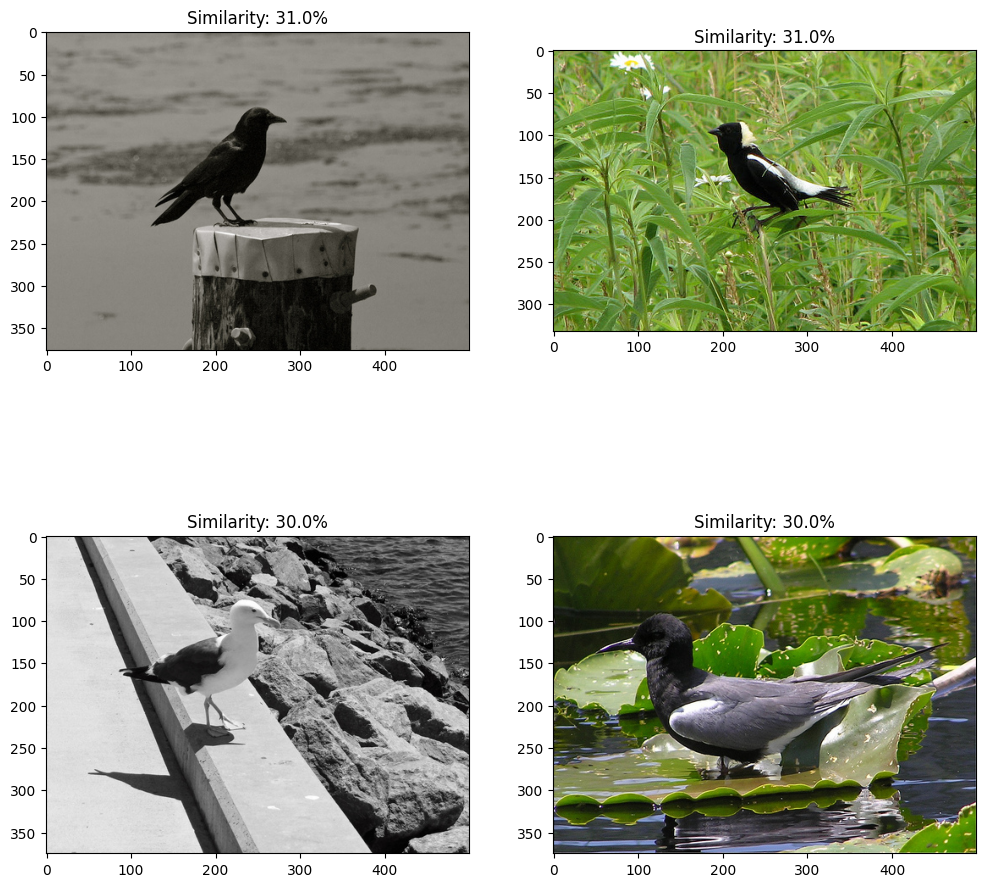

In [31]:
# query_caption = image_data_df.iloc[10].caption
# # Print the original query text
# print("Query: {}".format(query_caption))
# Run the similarity search
top_images = get_top_N_images("black and white bird", image_data_df)
# Plot the recommended images
plot_images_by_side(top_images)